In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 30 #higher precision
import csv
from PyMatching import *

In [11]:
#pymatching to compare to
num_shots = 100000
Ls = [4,6,8,10]
ps = np.linspace(0.01, 0.12, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...
Simulating L=8...
Simulating L=10...


In [12]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):  
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:                
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:    
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:    
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

In [13]:
batch_results = []

#probabilities = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]
probabilities = [0.01,0.02,0.03,0.04,0.05,0.06]
sizes = [8]

for p in probabilities:
    
    print('Probability',p)
    seed_range = range(100,200)
    
    p_res = []
    for size in sizes:
        
        print(size)
        
        size_res = []
        for seed in seed_range:
            seed_res = []
            all_good = True
            try:
                for error in ["I","X","Y","Z"]:
                    filename = "../results/periodic/prob_%6f"%p+"/X_%d"%size+"_Y_%d"%size+"/seed_%d"%seed+"/error_class_"+error+"/StitchedHistogram__intervals_40_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.csv"
                    E_list = []
                    log_g_list = []
                    with open(filename) as csv_file:
                        data = csv.reader(csv_file, delimiter=':')
                        for row in data:
                            E_list.append(int(row[0]))
                            log_g_list.append(float(row[1]))
                            
                    #To be removed once normalization is handled in c
                    offset = log_sum_exp(log_g_list)
                    rescaled_log_g_list = [res + mp.log(2)*size*size - offset for res in log_g_list]        
                    seed_res.append([E_list, rescaled_log_g_list])
            except:
                print('One or more error classes had an issue for seed',seed,'at size', size, ', probability',p)
                all_good = False

            if all_good:
                size_res.append(seed_res)
                
                
        p_res.append(size_res)
    batch_results.append(p_res)

Probability 0.01
8
Probability 0.02
8
Probability 0.03
8
Probability 0.04
8
Probability 0.05
8
Probability 0.06
8


In [14]:
free_energies_batch = []
for i, p in enumerate(probabilities):
    print('Probability',p)
    T_Nish = 1/(mp.log((1-p)/p)/2)  
    temperatures = [1e-20,T_Nish,1e20]
    free_energies_size = []
    for j in range(len(sizes)):
        print(size)
        free_energies = get_free_energies(batch_results[i][j],temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds:', len(free_energies))
        
    free_energies_batch.append(free_energies_size)

Probability 0.01
8
Number of seeds: 100
Probability 0.02
8
Number of seeds: 100
Probability 0.03
8
Number of seeds: 100
Probability 0.04
8
Number of seeds: 100
Probability 0.05
8
Number of seeds: 100
Probability 0.06
8
Number of seeds: 100


In [15]:
optimal_curves = []
T0_curves = []
for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    for j in range(len(sizes)):
        free_energies = free_energies_batch[i][j]
        
        temp = 1 #Nishimori temp
        res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
               or f_class[0][temp] < f_class[2][temp]\
               or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        optimal_curve.append(res)

        temp = 0 #Low temp
        res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
               or f_class[0][temp] < f_class[2][temp]\
               or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        T0_curve.append(res)
    
    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

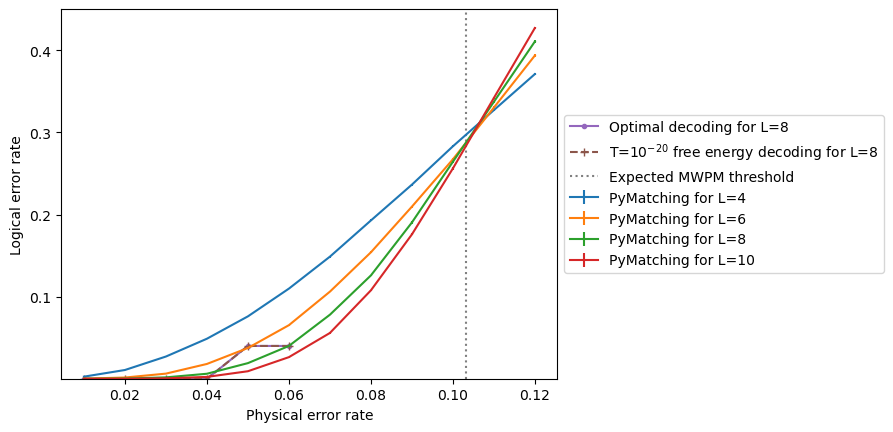

In [16]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))
    

for i, size in enumerate(sizes):
    plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
    plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)

plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()